# MOLNs Benchmarks

This notebook contains code to benchmark the DistributedEnsemble for the different storage modes. 

In [3]:
import IPython.parallel
from molnsutil import DistributedEnsemble
rc = IPython.parallel.Client()
view = rc.load_balanced_view()
import pyurdme
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
print "MOLNs cluster running with number of engines: {0}".format(len(rc.ids))

MOLNs cluster running with number of engines: 42


In [6]:
import pyurdme
import numpy
import mshr
import dolfin

class SimpleDiffusion(pyurdme.URDMEModel):
    """ This Hello World model follows a single
        species A diffusing on a unit square. Initially,  
        all N molecules are placed in the voxel closest 
        to the center of the domain and we simulate how 
        A spread by diffusion. This model is useful for benchmarking, 
        since it is easy to control the ratio of compute/data-I/O
        through the model paramters. 
    """
    
    def __init__(self, N=5000,D=0.01):
        
        pyurdme.URDMEModel.__init__(self,name="simple_diffusion")

        A = pyurdme.Species(name="A",diffusion_constant=D)
        B = pyurdme.Species(name="B",diffusion_constant=D)
        C = pyurdme.Species(name="C",diffusion_constant=D)

        self.add_species([A,B,C])
        
        cube = mshr.Box(dolfin.Point(numpy.array([0.0,0.0,0.0])),dolfin.Point(numpy.array([1.0,1.0,1.0])))
        self.mesh = pyurdme.URDMEMesh(mshr.generate_mesh(cube,10)) 
        
        # Place the A molecules in the voxel nearest the center of the square
        self.set_initial_condition_scatter({A:N})
        self.set_initial_condition_scatter({B:N})
        self.set_initial_condition_scatter({C:N})
        
        # Set the time frame for the study to [0,1], with results reported each 1e-3 seconds. 
        self.timespan(numpy.linspace(0,10,1001))

In [7]:
# We run it once so that the class will be enabled on all the engines.
ensemble = DistributedEnsemble(model_class=SimpleDiffusion)
res  = ensemble.add_realizations(number_of_trajectories=100)
res['wall_time']

Generating 100 realizations of the model (chunk size=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

28.877428

In [8]:
# Define a vector of engines 
num_engines = len(rc.ids)
engines = []
while num_engines > 1:
    engines.append(num_engines)
    num_engines=num_engines/2
engines.append(1)
engines.reverse()
print engines

[1, 2, 5, 10, 21, 42]


# Generating a distributed ensemble and Computing the mean value of a function

In [10]:
def g(result):
    """ Extract the spatial distribution of species A at the final timepoint. """
    import numpy
    A = result.get_species("A",-1)
    return A

# Strong scaling - the total work is constant and the number of engines increase (parallel efficiency)

We conduct scaling experiments by sequnentially doubling the number of engines used. 

### SharedStorage

In [11]:
import time
wall_time_strong_phase1 = []
wall_time_strong_phase2 = []
for num_engines in engines:
    # Phase1 - generate all the realizations and write them to disk
    ensemble = DistributedEnsemble(model_class=SimpleDiffusion,num_engines=num_engines)
    tic = time.time()
    res  = ensemble.add_realizations(number_of_trajectories=100)
    wall_time_1 = time.time()-tic
    wall_time_strong_phase1.append(wall_time_1)
    # Phase 2 - read all the realizations and compute the mean value
    tic = time.time()
    res = ensemble.mean(mapper=g)
    wall_time_2 = time.time()-tic
    wall_time_strong_phase2.append(wall_time_2)
    
    print "Number of engines: %i" % num_engines
    print "\tPhase1, wall_time: %f" % wall_time_1
    print "\tPhase2, wall_time: %f" % wall_time_2



Generating 100 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=100)


<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=1)
Number of engines: 1
	Phase1, wall_time: 30.548886
	Phase2, wall_time: 5.556568
Generating 100 realizations of the model (chunk size=50)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=50)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=2)
Number of engines: 2
	Phase1, wall_time: 35.577265
	Phase2, wall_time: 5.046318
Generating 100 realizations of the model (chunk size=20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=5)
Number of engines: 5
	Phase1, wall_time: 17.189763
	Phase2, wall_time: 3.519977
Generating 100 realizations of the model (chunk size=10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=10)
Number of engines: 10
	Phase1, wall_time: 12.628897
	Phase2, wall_time: 1.859826
Generating 100 realizations of the model (chunk size=5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=20)
Number of engines: 21
	Phase1, wall_time: 9.751226
	Phase2, wall_time: 1.491646
Generating 100 realizations of the model (chunk size=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=50)
Number of engines: 42
	Phase1, wall_time: 8.611930
	Phase2, wall_time: 1.742836


### PersistentStorage

In [12]:
# This test requires a working object store (S3 or Swift)
import time
wall_time_strong_persistent_phase1 = []
wall_time_strong_persistent_phase2 = []
for num_engines in engines:
    # Phase1 - generate all the realizations and write them to disk
    ensemble = DistributedEnsemble(model_class=SimpleDiffusion,num_engines=num_engines)
    tic = time.time()
    res  = ensemble.add_realizations(number_of_trajectories=100, storage_mode="Persistent")
    wall_time_1 = time.time()-tic
    wall_time_strong_persistent_phase1.append(wall_time_1)
    # Phase 2 - read all the realizations and compute the mean value
    tic = time.time()
    res = ensemble.mean(mapper=g)
    wall_time_2 = time.time()-tic
    wall_time_strong_persistent_phase2.append(wall_time_2)
    
    print "Number of engines: %i" % num_engines
    print "\tPhase1, wall_time: %f" % wall_time_1
    print "\tPhase2, wall_time: %f" % wall_time_2



Generating 100 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=100)


<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=1)
Number of engines: 1
	Phase1, wall_time: 56.392034
	Phase2, wall_time: 19.576242
Generating 100 realizations of the model (chunk size=50)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=50)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=2)
Number of engines: 2
	Phase1, wall_time: 70.578253
	Phase2, wall_time: 32.469412
Generating 100 realizations of the model (chunk size=20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=5)
Number of engines: 5
	Phase1, wall_time: 53.493450
	Phase2, wall_time: 28.508572
Generating 100 realizations of the model (chunk size=10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=10)
Number of engines: 10
	Phase1, wall_time: 43.474332
	Phase2, wall_time: 26.482854
Generating 100 realizations of the model (chunk size=5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=20)
Number of engines: 21
	Phase1, wall_time: 38.139323
	Phase2, wall_time: 25.775768
Generating 100 realizations of the model (chunk size=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=50)
Number of engines: 42
	Phase1, wall_time: 40.123040
	Phase2, wall_time: 34.390422


### Running without storage

In [13]:
import time
wall_time_no_storage = []
for num_engines in engines:
    tic = time.time()
    ensemble = DistributedEnsemble(model_class=SimpleDiffusion,num_engines=num_engines)
    res  = ensemble.mean(mapper=g, number_of_trajectories=100,store_realizations=False)
    wall_time = time.time()-tic
    wall_time_no_storage.append(wall_time)
    print "Number of engines: %i" % num_engines
    print "\tPhase1, wall_time: %f" % wall_time

Generating 100 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=1)
Number of engines: 1
	Phase1, wall_time: 31.848744
Generating 100 realizations of the model, running mapper & aggregator (chunk size=50)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=2)
Number of engines: 2
	Phase1, wall_time: 34.680414
Generating 100 realizations of the model, running mapper & aggregator (chunk size=20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=5)
Number of engines: 5
	Phase1, wall_time: 18.063560
Generating 100 realizations of the model, running mapper & aggregator (chunk size=10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=10)
Number of engines: 10
	Phase1, wall_time: 12.209307
Generating 100 realizations of the model, running mapper & aggregator (chunk size=5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=20)
Number of engines: 21
	Phase1, wall_time: 9.568129
Generating 100 realizations of the model, running mapper & aggregator (chunk size=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=50)
Number of engines: 42
	Phase1, wall_time: 7.951099


Populating the interactive namespace from numpy and matplotlib
[1, 2, 5, 10, 21, 42]
[56.39203405380249, 70.5782527923584, 53.49344992637634, 43.474332094192505, 38.139322996139526, 40.123040199279785]
[19.576241970062256, 32.469411849975586, 28.508572101593018, 26.48285412788391, 25.775768041610718, 34.390422105789185]
[30.54888606071472, 35.57726502418518, 17.189762830734253, 12.628896951675415, 9.75122594833374, 8.611930131912231]
[5.556568145751953, 5.046318054199219, 3.519976854324341, 1.859825849533081, 1.4916460514068604, 1.7428359985351562]
[31.84874391555786, 34.68041396141052, 18.063560009002686, 12.209306955337524, 9.568129062652588, 7.951098918914795]


`%matplotlib` prevents importing * from pylab and numpy


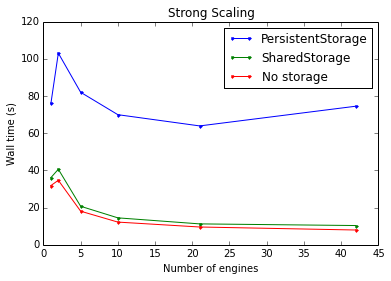

In [15]:
%pylab inline
print engines
print wall_time_strong_persistent_phase1
print wall_time_strong_persistent_phase2
print wall_time_strong_phase1
print wall_time_strong_phase2
print wall_time_no_storage
#plt.plot(engines, wall_time_strong_persistent_phase1, label="Phase1 - run pyurdme")
#plt.plot(engines, wall_time_strong_persistent_phase2, label="Phase2 - run postprocessing")
total = numpy.array(wall_time_strong_persistent_phase1)+numpy.array(wall_time_strong_persistent_phase2)
plt.plot(engines, total, ".-b", label="PersistentStorage")
#plt.plot(engines, wall_time_strong_phase1, label="Phase1 - run pyurdme")
#plt.plot(engines, wall_time_strong_phase2, label="Phase2 - run postprocessing")
total = numpy.array(wall_time_strong_phase1)+numpy.array(wall_time_strong_phase2)
plt.plot(engines, total, ".-g", label="SharedStorage")
plt.plot(engines, wall_time_no_storage, ".-r", label="No storage")
plt.legend()
plt.xlabel("Number of engines")
plt.ylabel("Wall time (s)")
plt.title("Strong Scaling")
plt.show()

In [ ]:
#Clean up
from molnsutil import PersistentStorage
ps = PersistentStorage()
ps.delete_all()

# Weak scaling - The work per engine stays constant as the number of engines increase

### SharedStorage

In [16]:
import time
wall_time_weak_shared_phase1 = []
wall_time_weak_shared_phase2 = []
for num_engines in engines:
    # Phase1 - generate all the realizations and write them to disk
    ensemble = DistributedEnsemble(model_class=SimpleDiffusion, num_engines=num_engines)
    tic = time.time()
    res  = ensemble.add_realizations(number_of_trajectories=100*num_engines)
    wall_time_1 = time.time()-tic
    wall_time_weak_shared_phase1.append(wall_time_1)
    # Phase 2 - read all the realizations and compute the mean value
    tic = time.time()
    res = ensemble.mean(mapper=g)
    wall_time_2 = time.time()-tic
    wall_time_weak_shared_phase2.append(wall_time_2)
    
    print "Number of engines: %i" % num_engines
    print "\tPhase1, wall_time: %f" % wall_time_1
    print "\tPhase2, wall_time: %f" % wall_time_2

Generating 100 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=100)


<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=1)
Number of engines: 1
	Phase1, wall_time: 29.387689
	Phase2, wall_time: 4.708782
Generating 200 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=200, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=2)
Number of engines: 2
	Phase1, wall_time: 59.226547
	Phase2, wall_time: 11.116545
Generating 500 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=500, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=5)
Number of engines: 5
	Phase1, wall_time: 63.708791
	Phase2, wall_time: 19.378108
Generating 1000 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=1000, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=10)
Number of engines: 10
	Phase1, wall_time: 68.602846
	Phase2, wall_time: 17.413965
Generating 2100 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=2100, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=21)
Number of engines: 21
	Phase1, wall_time: 77.756525
	Phase2, wall_time: 31.472699
Generating 4200 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=4200, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=42)
Number of engines: 42
	Phase1, wall_time: 103.040503
	Phase2, wall_time: 62.532916


### PersistentStorage

In [17]:
# This test requires a working object store (S3 or Swift)
import time
wall_time_weak_persistent_phase1 = []
wall_time_weak_persistent_phase2 = []
for num_engines in engines:
    # Phase1 - generate all the realizations and write them to disk
    ensemble = DistributedEnsemble(model_class=SimpleDiffusion,num_engines=num_engines)
    tic = time.time()
    res  = ensemble.add_realizations(number_of_trajectories=100*num_engines, storage_mode="Persistent")
    wall_time_1 = time.time()-tic
    wall_time_weak_persistent_phase1.append(wall_time_1)
    # Phase 2 - read all the realizations and compute the mean value
    tic = time.time()
    res = ensemble.mean(mapper=g)
    wall_time_2 = time.time()-tic
    wall_time_weak_persistent_phase2.append(wall_time_2)
    
    print "Number of engines: %i" % num_engines
    print "\tPhase1, wall_time: %f" % wall_time_1
    print "\tPhase2, wall_time: %f" % wall_time_2

Generating 100 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=100, chunk size=100)


<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=1)
Number of engines: 1
	Phase1, wall_time: 56.111962
	Phase2, wall_time: 19.114808
Generating 200 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=200, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=2)
Number of engines: 2
	Phase1, wall_time: 108.496751
	Phase2, wall_time: 38.700424
Generating 500 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=500, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=5)
Number of engines: 5
	Phase1, wall_time: 142.265845
	Phase2, wall_time: 40.871854
Generating 1000 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=1000, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=10)
Number of engines: 10
	Phase1, wall_time: 201.431058
	Phase2, wall_time: 40.401661
Generating 2100 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=2100, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=21)
Number of engines: 21
	Phase1, wall_time: 337.622785
	Phase2, wall_time: 44.578453
Generating 4200 realizations of the model (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running mapper & aggregator on the result objects (number of results=4200, chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=42)
Number of engines: 42
	Phase1, wall_time: 592.731548
	Phase2, wall_time: 50.067833


### Running without storage

In [18]:
import time
wall_time_weak_no_storage = []
for num_engines in engines:
    tic = time.time()
    ensemble = DistributedEnsemble(model_class=SimpleDiffusion,num_engines=num_engines)
    res  = ensemble.mean(mapper=g, number_of_trajectories=100*num_engines, store_realizations=False)
    wall_time = time.time()-tic
    wall_time_weak_no_storage.append(wall_time)
    print "Number of engines: %i" % num_engines
    print "\tPhase1, wall_time: %f" % wall_time

Generating 100 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=1)
Number of engines: 1
	Phase1, wall_time: 30.388981
Generating 200 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=2)
Number of engines: 2
	Phase1, wall_time: 62.999479
Generating 500 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=5)
Number of engines: 5
	Phase1, wall_time: 59.246945
Generating 1000 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=10)
Number of engines: 10
	Phase1, wall_time: 60.225044
Generating 2100 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=21)
Number of engines: 21
	Phase1, wall_time: 59.092597
Generating 4200 realizations of the model, running mapper & aggregator (chunk size=100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running reducer on mapped and aggregated results (size=42)
Number of engines: 42
	Phase1, wall_time: 60.481775


[1, 2, 5, 10, 21, 42]
[56.11196208000183, 108.49675107002258, 142.2658450603485, 201.43105792999268, 337.62278485298157, 592.7315480709076]
[19.114807844161987, 38.70042395591736, 40.871853828430176, 40.40166115760803, 44.578453063964844, 50.067832946777344]
[29.387688875198364, 59.22654700279236, 63.70879101753235, 68.60284614562988, 77.75652503967285, 103.04050278663635]
[4.708781957626343, 11.116544961929321, 19.378108024597168, 17.413964986801147, 31.47269892692566, 62.53291606903076]
[30.388981103897095, 62.99947905540466, 59.24694514274597, 60.2250440120697, 59.092597007751465, 60.4817750453949]


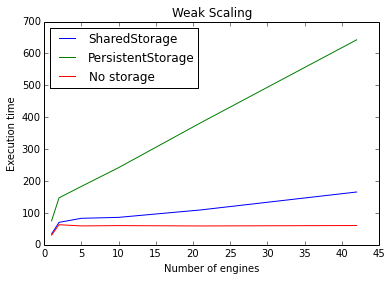

In [19]:
print engines
print wall_time_weak_persistent_phase1
print wall_time_weak_persistent_phase2
print wall_time_weak_shared_phase1
print wall_time_weak_shared_phase2
print wall_time_weak_no_storage

total = numpy.array(wall_time_weak_shared_phase1) + numpy.array(wall_time_weak_shared_phase2)
plt.plot(engines, total, label="SharedStorage")
total = numpy.array(wall_time_weak_persistent_phase1) + numpy.array(wall_time_weak_persistent_phase2)
plt.plot(engines, total, label="PersistentStorage")
plt.plot(engines, wall_time_weak_no_storage, label="No storage")
plt.legend(loc='best')
plt.xlabel("Number of engines")
plt.ylabel("Execution time")
plt.title("Weak Scaling")

In [20]:
#Clean up
from molnsutil import PersistentStorage
ps = PersistentStorage()
ps.delete_all()